In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

Device setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


 Load pre-trained model

In [ ]:
model = models.resnet18(pretrained=True)
# Freeze all convolutional layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for CIFAR-10 (10 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


Load CIFAR-10 dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_dataset = datasets.CIFAR10(root='~/.keras/datasets', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='~/.keras/datasets', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:08<00:00, 20.3MB/s]


Loss and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Training Loop

In [ ]:
epochs = 10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(epochs):
    # Training
    model.train()
    running_loss, running_corrects = 0.0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            val_corrects += (outputs.argmax(1) == labels).sum().item()

    val_epoch_loss = val_loss / len(test_dataset)
    val_epoch_acc = val_corrects / len(test_dataset)
    test_losses.append(val_epoch_loss)
    test_accuracies.append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch [1/10] Train Loss: 0.8278, Train Acc: 0.7322 Val Loss: 0.6560, Val Acc: 0.7771
Epoch [2/10] Train Loss: 0.6163, Train Acc: 0.7876 Val Loss: 0.6097, Val Acc: 0.7883
Epoch [3/10] Train Loss: 0.5886, Train Acc: 0.7969 Val Loss: 0.5841, Val Acc: 0.7987
Epoch [4/10] Train Loss: 0.5787, Train Acc: 0.7993 Val Loss: 0.5832, Val Acc: 0.8028
Epoch [5/10] Train Loss: 0.5645, Train Acc: 0.8037 Val Loss: 0.5793, Val Acc: 0.8035
Epoch [6/10] Train Loss: 0.5607, Train Acc: 0.8049 Val Loss: 0.5681, Val Acc: 0.8028
Epoch [7/10] Train Loss: 0.5538, Train Acc: 0.8090 Val Loss: 0.5576, Val Acc: 0.8089
Epoch [8/10] Train Loss: 0.5520, Train Acc: 0.8086 Val Loss: 0.5646, Val Acc: 0.8061
Epoch [9/10] Train Loss: 0.5500, Train Acc: 0.8100 Val Loss: 0.5655, Val Acc: 0.8062
Epoch [10/10] Train Loss: 0.5467, Train Acc: 0.8106 Val Loss: 0.5623, Val Acc: 0.8095


Plot Accuracy and Loss

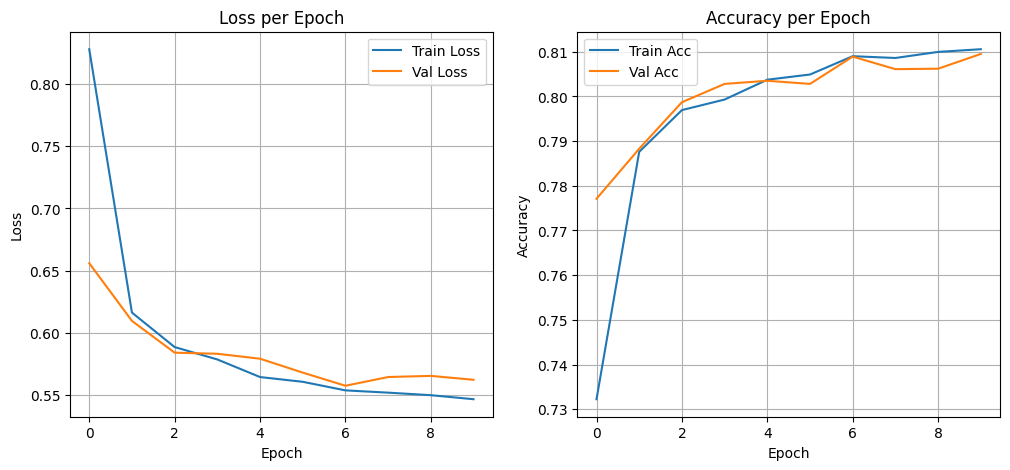

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

Display sample predictions

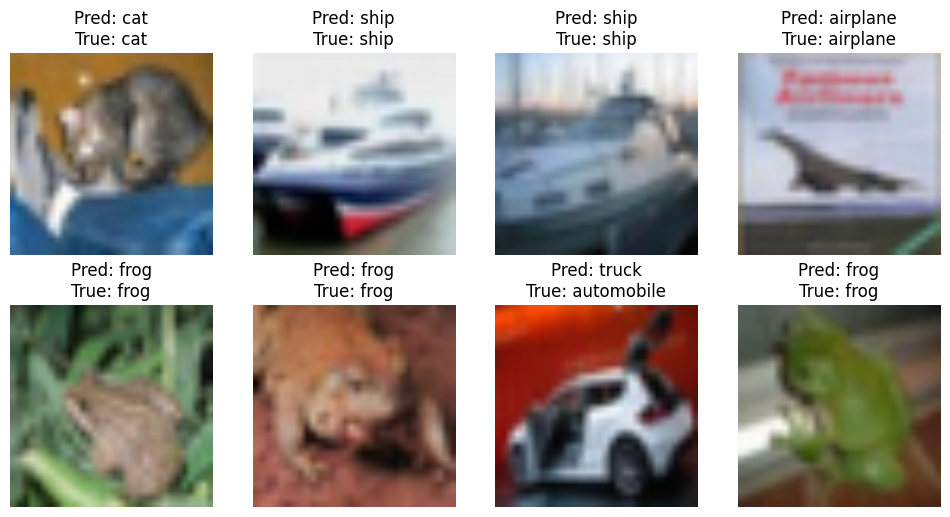

In [ ]:
import matplotlib.pyplot as plt

classes = train_dataset.classes
model.eval()
imgs, labels = next(iter(test_loader))
imgs, labels = imgs.to(device), labels.to(device)
outputs = model(imgs)
preds = outputs.argmax(1)

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    img_np = imgs[i].cpu().permute(1,2,0).numpy()
    img_np = img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])  # denormalize
    img_np = np.clip(img_np,0,1)
    plt.imshow(img_np)
    plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
    plt.axis('off')
plt.show()
